In [1]:
# Imports
import gc
import json
import os
import random
import sys
import tempfile
import argparse
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# Relative Imports
package_path = Path(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))  # TODO: change to elmneuron path
sys.path.insert(0, str(package_path))

from src.expressive_leaky_memory_neuron_initialization import ELM
from src.expressive_leaky_memory_neuron_forget import ELMf
from src.parity_tasks import make_batch_Nbit_pair_parity, make_batch_Nbit_pair_paritysum

In [2]:
short_run=False
forget_gate=False
learn_mem_tau=True
curriculum=False
Nsum=True
save_model=False

N = 32
delayed_response = 0
num_memory = 120
mlp_hidden_size = -1
mlp_num_layers = 1
max_tau = 50.0

seed = 1028

In [3]:
########## General Config ##########
print("General configuration started...")

# General Config
general_config = dict()
general_config["seed"] = seed
general_config["device"] = "cuda" if torch.cuda.is_available() else "cpu"
general_config["short_training_run"] = short_run
general_config["verbose"] = general_config["short_training_run"]
torch_device = torch.device(general_config["device"])
print("Torch Device: ", torch_device)

# Seeding & Determinism
os.environ["PYTHONHASHSEED"] = str(general_config["seed"])
random.seed(general_config["seed"])
np.random.seed(general_config["seed"])
torch.manual_seed(general_config["seed"])
torch.cuda.manual_seed(general_config["seed"])
torch.backends.cudnn.deterministic = True

########## Data, Model and Training Config ##########
print("Data, model and training configuration started...")


# Data Config

data_config = dict()
data_config["N"] = N
data_config['curriculum'] =  curriculum
data_config["Nsum"] =  Nsum
Ns = [N]

# Model Config

model_config = dict()
model_config["num_input"] = 1
model_config["num_output"] = 3 if data_config["Nsum"] else 2
model_config["num_memory"] =  num_memory
model_config["mlp_num_layers"] =  mlp_num_layers
model_config["mlp_hidden_size"] =  mlp_hidden_size if  mlp_hidden_size>0 else 2*model_config["num_memory"]
model_config["memory_tau_min"] = 1.0
model_config["memory_tau_max"] = max_tau
model_config["tau_b_value"] = 0.0
model_config["learn_memory_tau"] =  learn_mem_tau
model_config["num_synapse_per_branch"] = 1

# Training Config

train_config = dict()
train_config['forget_gate'] =  forget_gate
train_config["learning_rate"] = 5e-4
train_config["batch_size"] = 32 if general_config["short_training_run"] else 32
train_config["batches_per_epoch"] = 2000000 if general_config["short_training_run"] else 1000
train_config["batches_per_epoch"] = int(8/train_config["batch_size"] * train_config["batches_per_epoch"])
train_config["delayed_response"] =  delayed_response
delay = train_config["delayed_response"]
reset_optimizer = False


########## Data, Model and Training Setup ##########


General configuration started...
Torch Device:  cuda
Data, model and training configuration started...


In [4]:
print("Data, model and training setup started...")
save_dir_critical = "../models/new_exp/parity_best_model_forget_False_N_32_nummem_120.pt"
save_dir_success = "../models/new_exp/parity_best_model_forget_False_N_32_nummem_120_20250428.pt"
save_dir_fail = "../models/new_exp/parity_best_model_forget_False_N_32_nummem_120_20250208.pt"
# Initialize the ELM model
model_critical = ELM(**model_config).to(torch_device)
model_success  = ELM(**model_config).to(torch_device)
model_fail     = ELM(**model_config).to(torch_device)

# Visualize ELM model
state_dict_critical = torch.load(save_dir_critical, map_location=torch_device, weights_only=False)
print(model_critical.load_state_dict(state_dict_critical))

state_dict_success = torch.load(save_dir_success, map_location=torch_device, weights_only=False)
print(model_success.load_state_dict(state_dict_success))

state_dict_fail = torch.load(save_dir_fail, map_location=torch_device, weights_only=False)
print(model_fail.load_state_dict(state_dict_fail))
# Visualize ELM model

Data, model and training setup started...
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [5]:
##eval
model_critical.eval()
model_success.eval()
model_fail.eval()
sequences, labels = make_batch_Nbit_pair_paritysum(Ns, train_config["batch_size"], duplicate=1, classify_in_time=True, device=torch_device, delay = delay)
parity, Nsum = labels[0]
# Perform a single batch
outputs_c, mlp_record_c, m_record_c = model_critical.parity_viz_forward(sequences)
outputs_s, mlp_record_s, m_record_s = model_success.parity_viz_forward(sequences)
outputs_f, mlp_record_f, m_record_f = model_fail.parity_viz_forward(sequences)
outputs_c = outputs_c[:, Ns[0]-1:].permute(0, 2, 1)
outputs_s = outputs_s[:, Ns[0]-1:].permute(0, 2, 1)
outputs_f = outputs_f[:, Ns[0]-1:].permute(0, 2, 1)
m_record_c = m_record_c.cpu().detach().numpy()
m_record_s = m_record_s.cpu().detach().numpy()
m_record_f = m_record_f.cpu().detach().numpy()
mlp_record_c = mlp_record_c.cpu().detach().numpy()
mlp_record_s = mlp_record_s.cpu().detach().numpy()
mlp_record_f = mlp_record_f.cpu().detach().numpy()

#_, prediction = torch.max(outputs[:,:2,delay:], dim=1)
#acc = ((prediction==parity) * 1.).mean()

#print(acc)

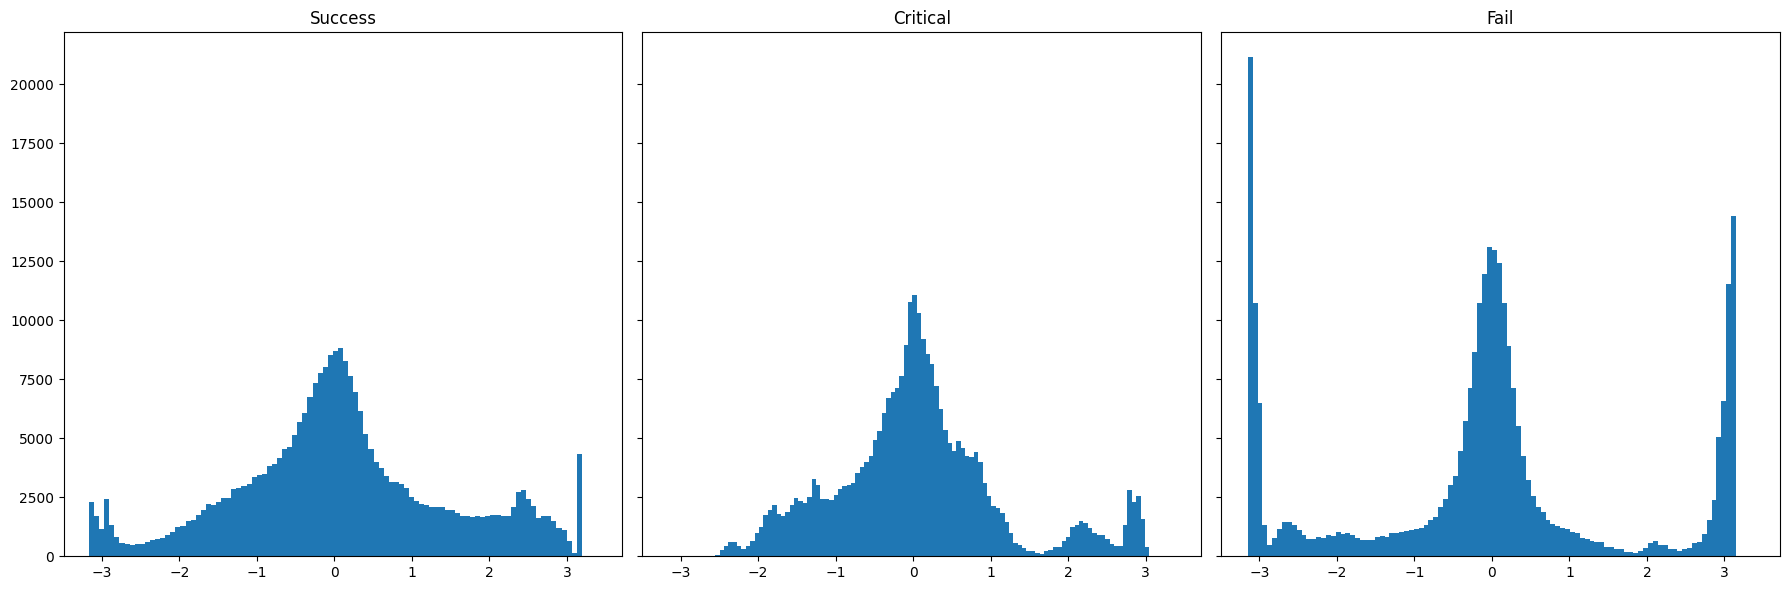

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
axs[0].hist(m_record_s.flatten(), bins=100)
axs[0].set_title("Success")
axs[1].hist(m_record_c.flatten(), bins=100)
axs[1].set_title("Critical")
axs[2].hist(m_record_f.flatten(), bins=100)
axs[2].set_title("Fail")

plt.tight_layout()
plt.show()

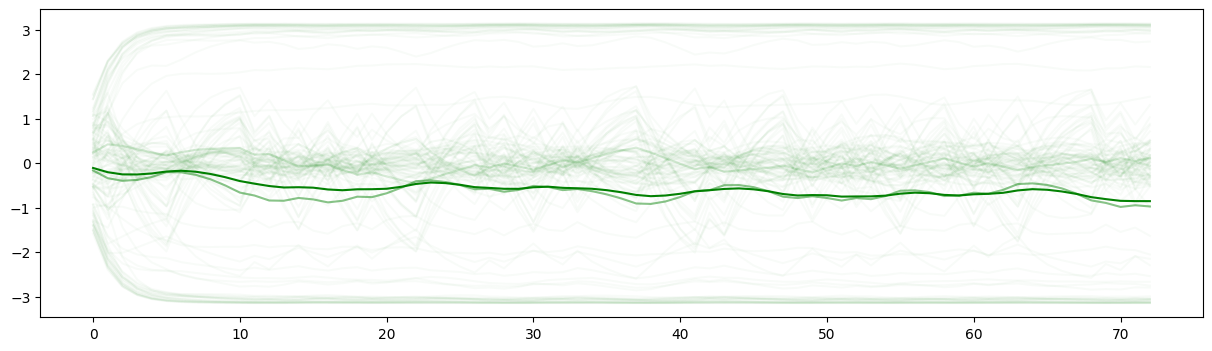

In [7]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_fail.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(m_record_f[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

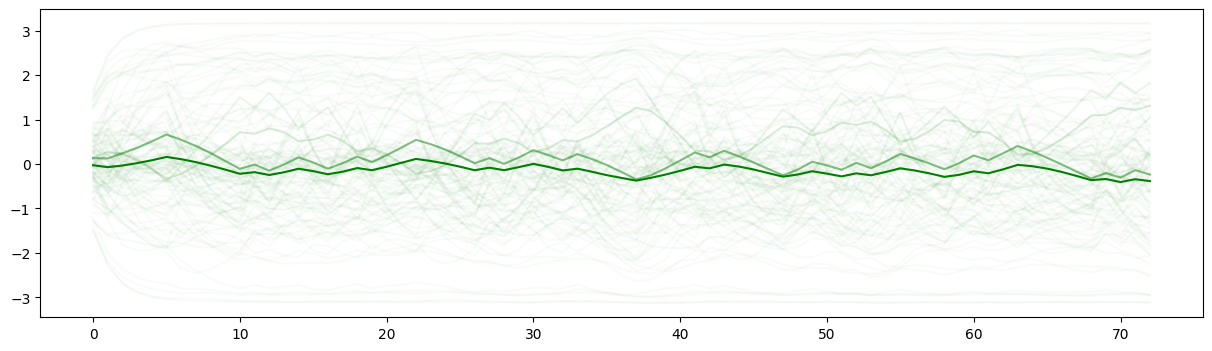

In [8]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_success.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(m_record_s[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

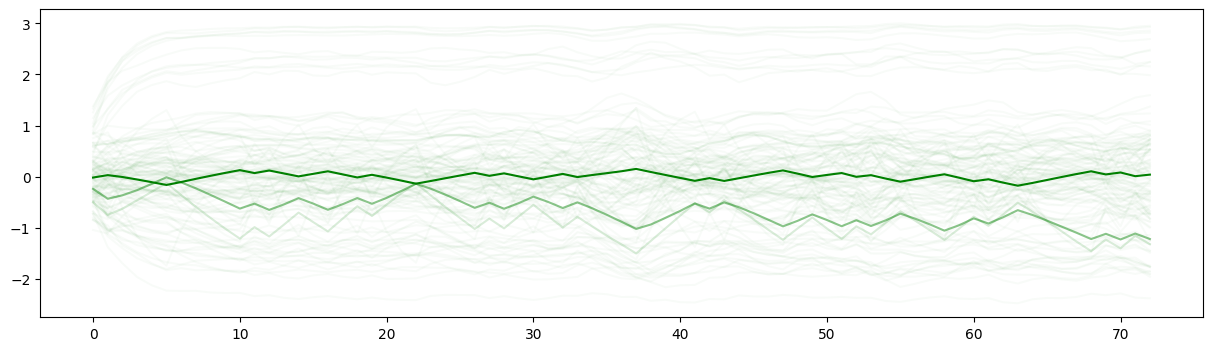

In [9]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_critical.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(m_record_c[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

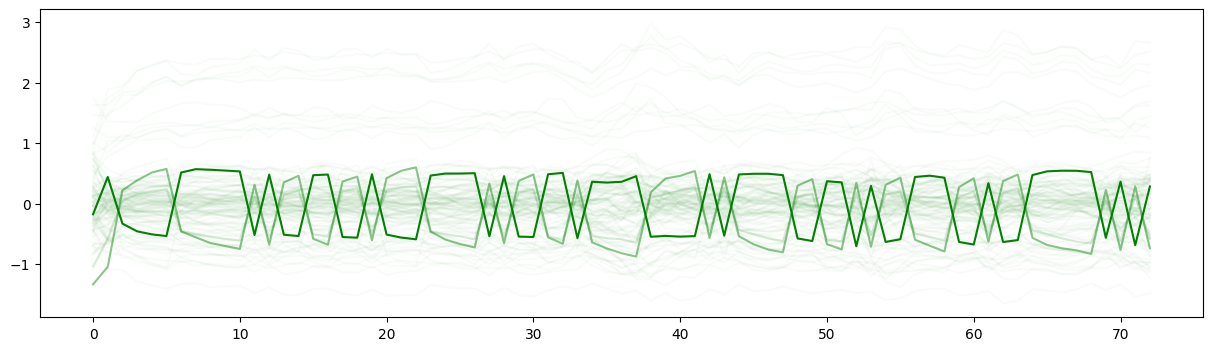

In [10]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_critical.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(mlp_record_c[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

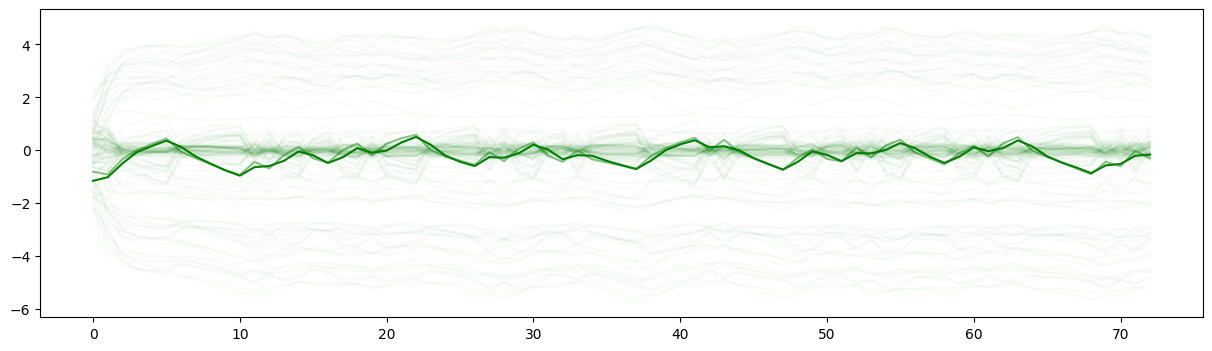

In [11]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_fail.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(mlp_record_f[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

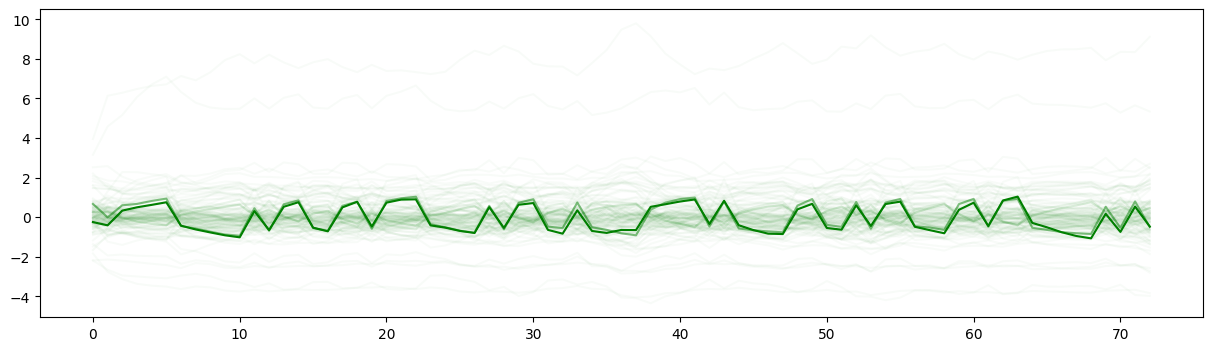

In [12]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_success.tau_m.cpu()
for i in range(120):
    tau=tau_m[i].item()
    plt.plot(mlp_record_s[0, :, i], label=tau, color=('green', tau/50))
#plt.legend()
plt.show()

In [39]:
state_dict_fail

OrderedDict([('_proto_w_s', tensor([0.8733], device='cuda:0')),
             ('tau_b', tensor([0.], device='cuda:0')),
             ('_proto_tau_m',
              tensor([ 4.2235, -0.1756, -1.8707, -3.1144, -3.7493, -4.3809, -9.6953, -5.0456,
                      -4.9948, -4.8918, -5.0438, -5.0315, -5.0918, -4.9819, -5.0732, -4.9886,
                      -5.0005, -5.1600, -5.0499, -5.0436, -4.9388, -4.8245, -5.0851, -5.1547,
                      -4.9409, -5.0022, -4.9112, -5.0741, -4.8915, -5.0507, -5.0260, -4.9558,
                      -5.0080, -4.9178, -5.0304, -5.0811, -5.0622, -5.0997, -5.0936, -5.0083,
                      -5.0793, -5.0427, -5.1033, -5.0927, -5.1777, -4.9179, -4.7790, -5.0248,
                      -5.0577, -5.0780, -4.9703, -5.0496, -5.1010, -4.9633, -4.9339, -4.9142,
                      -5.0630, -5.0280, -4.9578, -4.8274, -4.9268, -5.0449, -5.0010, -4.6995,
                      -4.8505, -5.0699, -4.9274, -5.0208, -5.0234, -4.9774, -4.9831, -4.9013,
     

In [45]:
state_dict_success

OrderedDict([('_proto_w_s', tensor([1.0726], device='cuda:0')),
             ('tau_b', tensor([0.], device='cuda:0')),
             ('_proto_tau_m',
              tensor([ 4.6245, -0.0873, -1.8698, -2.7886, -4.0413, -4.5104, -9.7461, -4.9232,
                      -5.0551, -5.0186, -5.1495, -4.9013, -5.0059, -4.9083, -5.0891, -5.0067,
                      -4.9615, -4.9187, -4.9976, -5.1884, -5.0277, -4.9893, -5.0055, -5.0845,
                      -4.8943, -4.9090, -4.9115, -4.7747, -4.9310, -4.7244, -5.0081, -5.0181,
                      -5.0326, -5.0543, -4.8538, -4.8492, -5.0209, -4.9163, -5.0417, -5.0620,
                      -5.1565, -4.8816, -5.0504, -4.9713, -4.9075, -5.0321, -4.8875, -5.0189,
                      -5.0319, -5.0318, -4.9989, -5.0383, -4.8784, -4.9879, -4.8567, -5.0365,
                      -5.0444, -4.8809, -5.0212, -5.0319, -5.0162, -5.0256, -5.0800, -5.1009,
                      -4.9078, -4.9600, -4.9281, -5.0561, -4.9962, -5.1943, -4.9649, -4.9998,
     

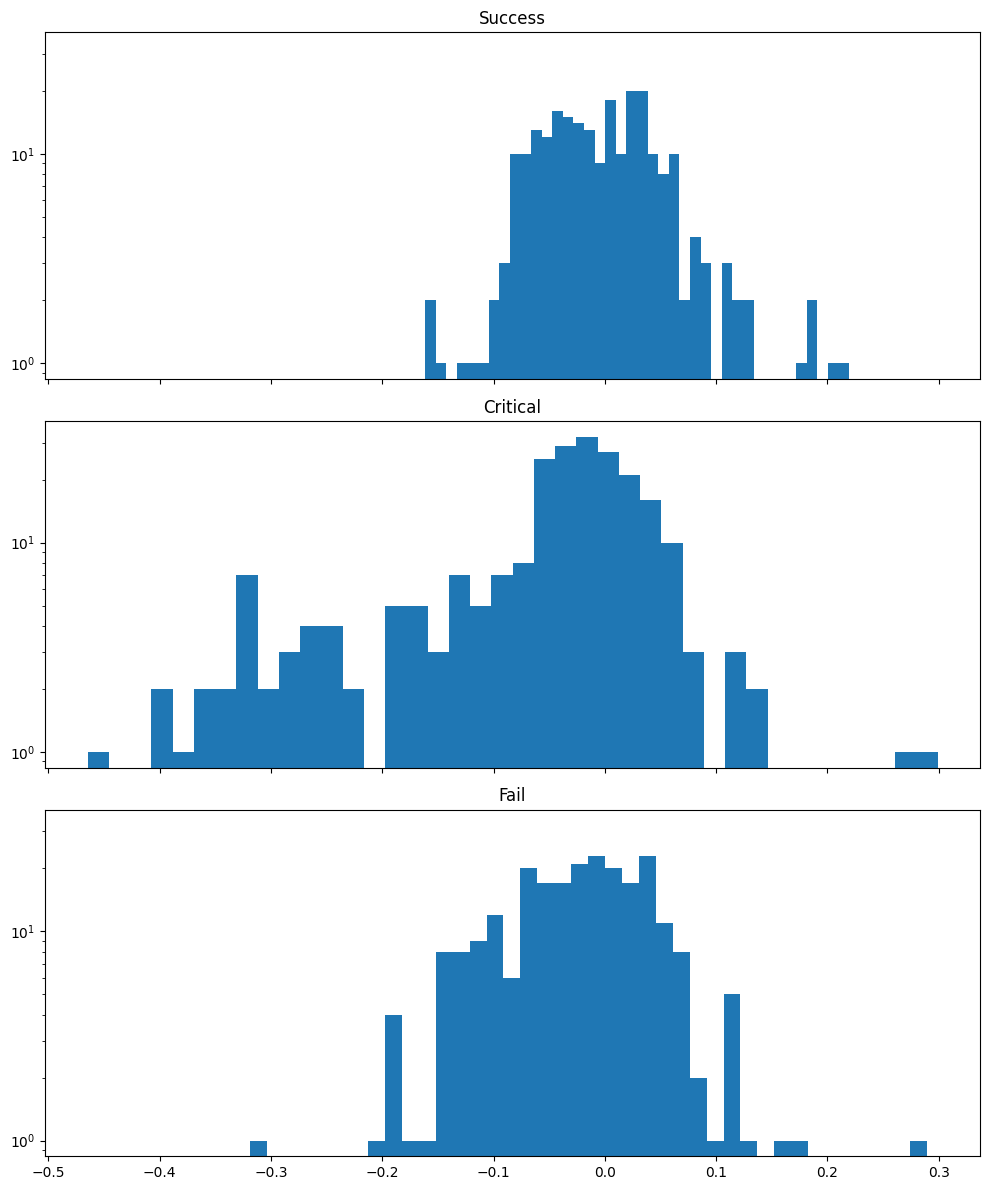

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(10,12), sharex=True, sharey=True)
axs[0].hist(state_dict_success['mlp.network.2.weight'].cpu().numpy().flatten(), bins = 40)
axs[0].set_title("Success")
axs[1].hist(state_dict_critical['mlp.network.2.weight'].cpu().numpy().flatten(), bins = 40)
axs[1].set_title("Critical")
axs[2].hist(state_dict_fail['mlp.network.2.weight'].cpu().numpy().flatten(), bins = 40)
axs[2].set_title("Fail")
axs[2].set_yscale("log")

plt.tight_layout()
plt.show()

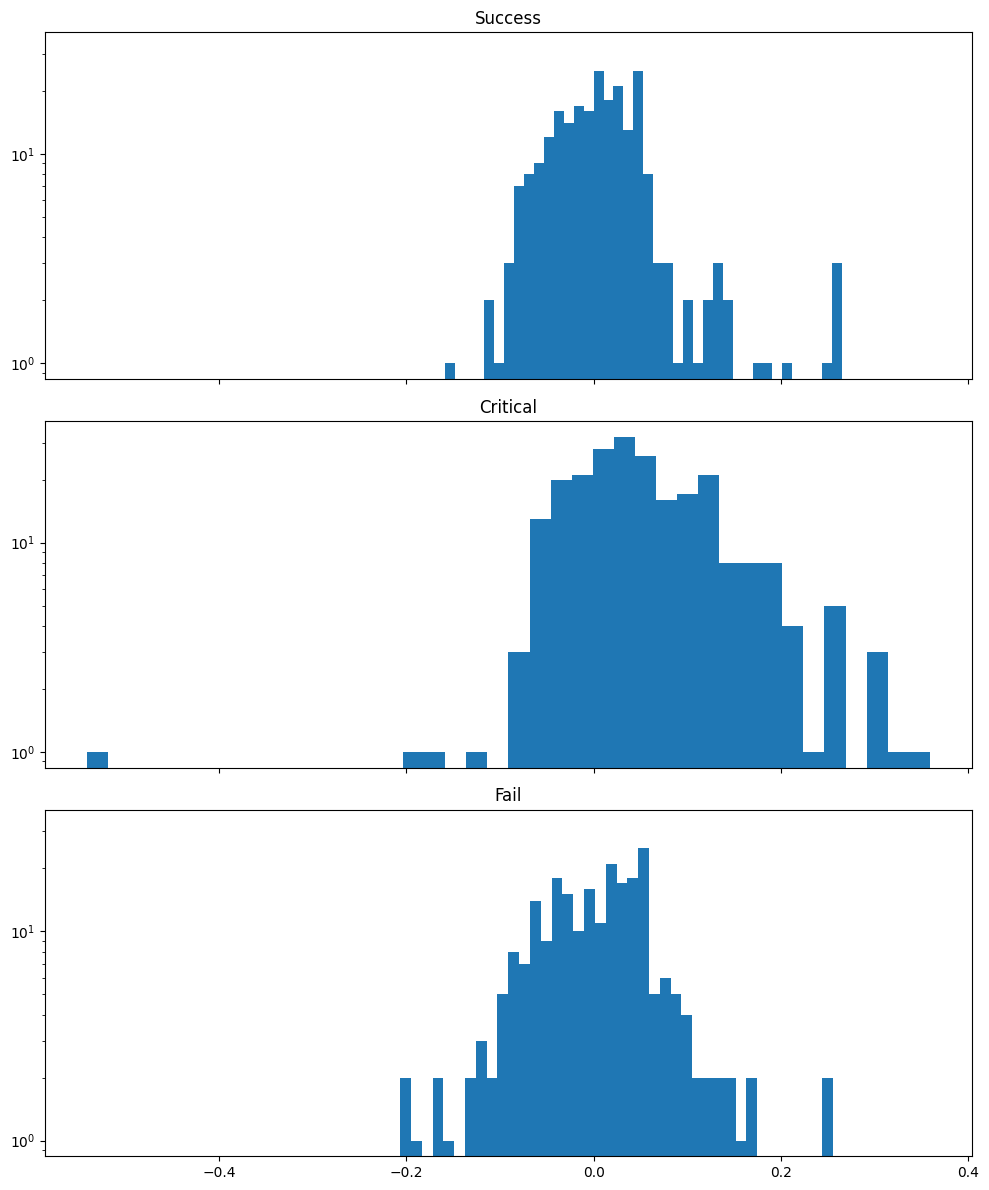

In [26]:
i=51
fig, axs = plt.subplots(3, 1, figsize=(10,12), sharex=True, sharey=True)
axs[0].hist(state_dict_success['mlp.network.2.weight'].cpu().numpy()[i].flatten(), bins = 40)
axs[0].set_title("Success")
axs[1].hist(state_dict_critical['mlp.network.2.weight'].cpu().numpy()[i].flatten(), bins = 40)
axs[1].set_title("Critical")
axs[2].hist(state_dict_fail['mlp.network.2.weight'].cpu().numpy()[i].flatten(), bins = 40)
axs[2].set_title("Fail")
axs[2].set_yscale("log")

plt.tight_layout()
plt.show()

In [16]:
state_dict_success['w_y.weight'].shape

torch.Size([3, 120])

In [42]:
model_init = ELM(**model_config).to(torch_device)

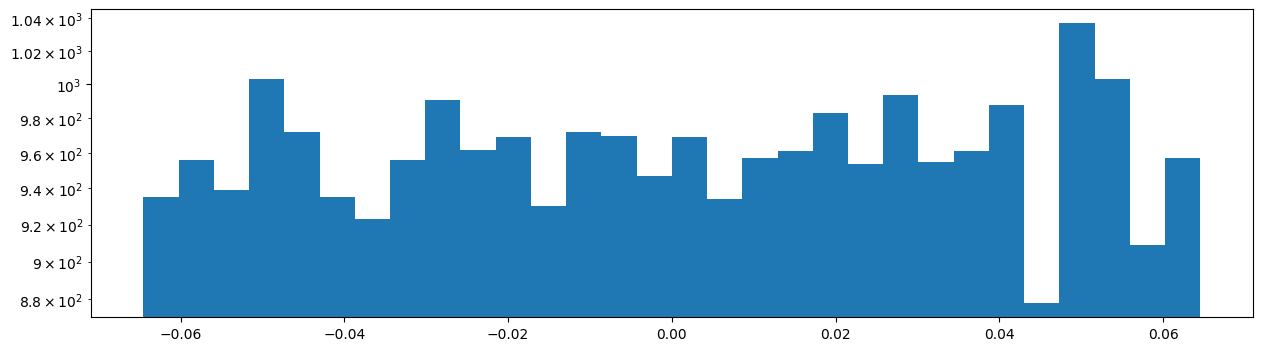

In [44]:
fig = plt.figure(figsize = (15, 4))
plt.hist(model_init.state_dict()['mlp.network.2.weight'].cpu().numpy().flatten(), bins = 30)
plt.yscale('log')
plt.show()

In [44]:
print("Data, model and training setup started...")
##No average, with L2 norm, no 0-mean, no symmetric inital, produce double peak
##save_dir_avg = "../models/new_exp/fail/parity_best_model_forget_False_N_40_nummem_100_20250207.pt" 
save_dir_avg = "../models/new_exp/fail/parity_best_model_forget_False_N_40_nummem_100_206.pt" 
# Initialize the ELM model
model_config_avg = model_config.copy()
model_config_avg["num_memory"] = 100
model_config_avg["mlp_hidden_size"] = 200
model_config_avg["memory_tau_min"] = 0.1
model_config_avg["memory_tau_max"] = 60.
model_avg = ELM(**model_config_avg).to(torch_device)

# Visualize ELM model
state_dict_avg = torch.load(save_dir_avg, map_location=torch_device, weights_only=False)
print(model_avg.load_state_dict(state_dict_avg))

Data, model and training setup started...
<All keys matched successfully>


In [45]:
model_avg.eval()
# Perform a single batch
outputs_a, mlp_record_a, m_record_a = model_avg.parity_viz_forward(sequences)
outputs_a = outputs_a[:, Ns[0]-1:].permute(0, 2, 1)
m_record_a = m_record_a.cpu().detach().numpy()
mlp_record_a = mlp_record_a.cpu().detach().numpy()

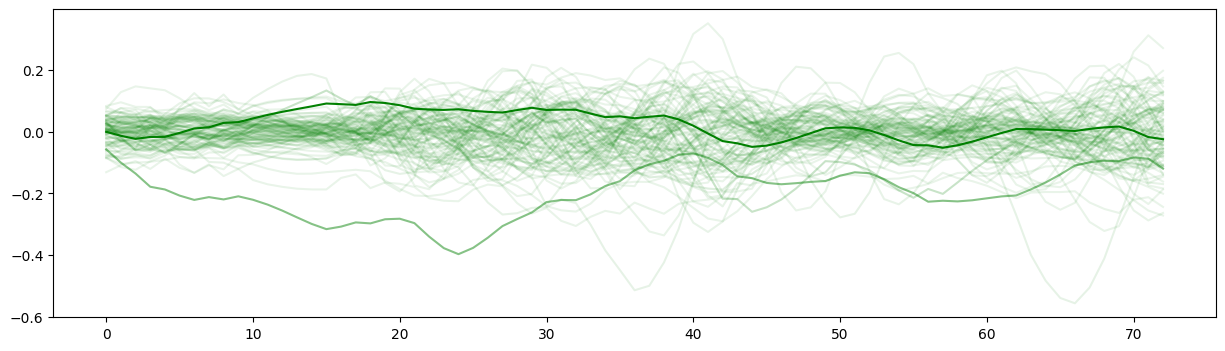

In [46]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_avg.tau_m.cpu()
for i in range(model_config_avg["num_memory"]):
    tau=tau_m[i].item()
    plt.plot(m_record_a[0, :, i], label=tau, color=('green', (tau+5)/(model_config_avg["memory_tau_max"]+5)))
#plt.legend()
plt.show()

In [47]:
model_avg.mlp.network[2].weight.mean(dim=1).shape

torch.Size([100])

In [48]:
m_record_a[0].mean(axis=0).argmax()

np.int64(54)

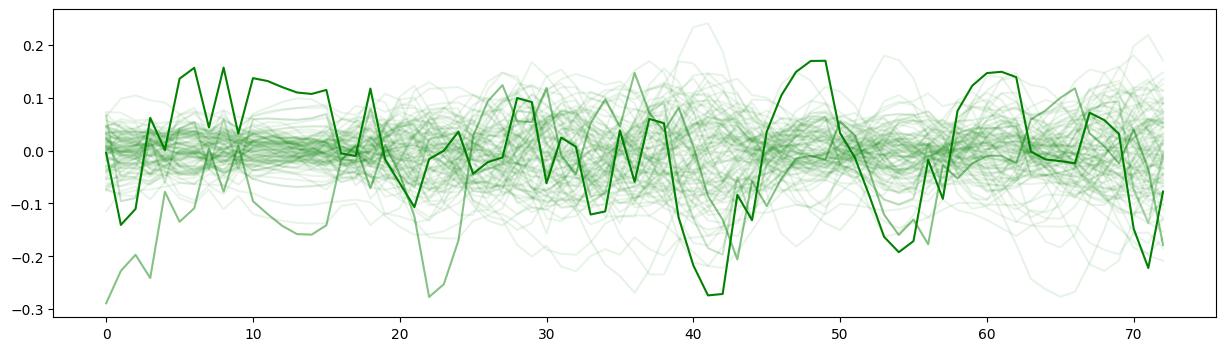

In [49]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_avg.tau_m.cpu()
for i in range(model_config_avg["num_memory"]):
    tau=tau_m[i].item()
    plt.plot(mlp_record_a[0, :, i], label=tau, color=('green', (tau+5)/(model_config_avg["memory_tau_max"]+5)))
#plt.legend()
plt.show()

In [50]:
model_avg.mlp.network[2].weight.shape

torch.Size([100, 200])

In [51]:
(mlp_record_a[0].mean(axis=0))[47]

np.float32(0.0019756276)

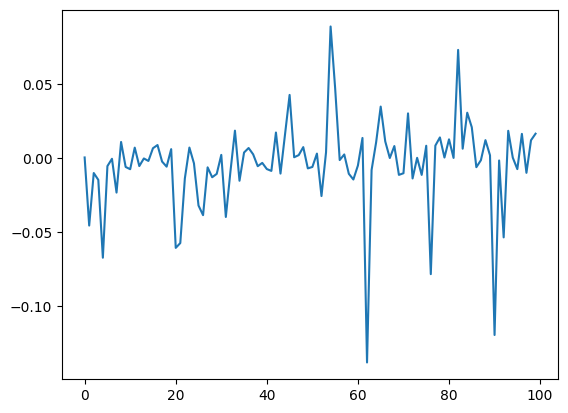

In [52]:
plt.plot(mlp_record_a[0].mean(axis=0))

In [53]:
mlp_record_a[5].var(axis=0).argmin()

np.int64(6)

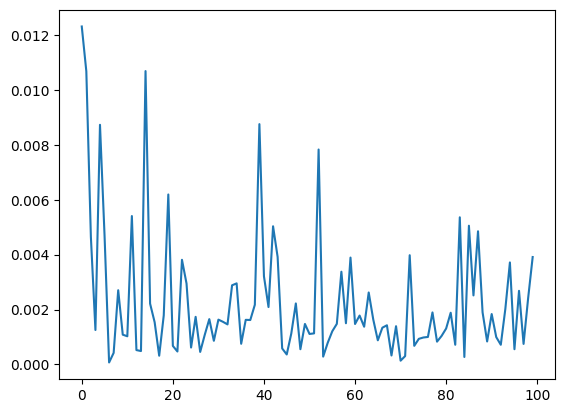

In [54]:
plt.plot(mlp_record_a[0].var(axis=0))

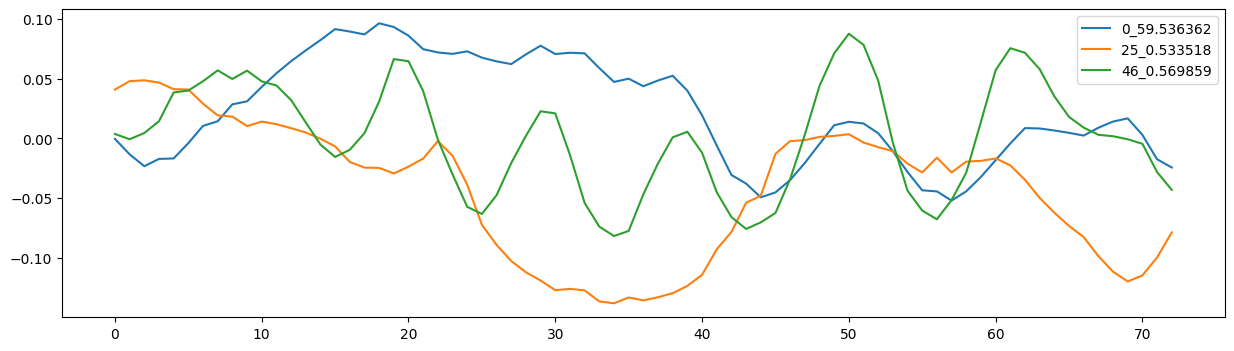

In [55]:
fig = plt.figure(figsize = (15, 4))
tau_m = model_avg.tau_m.cpu()
#for i in [0, 25, 46, 49, 51, 52, 53]:
for i in [0, 25, 46]:
    tau=tau_m[i].item()
    plt.plot(m_record_a[0, :, i], label="%d_%2f"%(i,tau))
plt.legend()
plt.show()

(100, 200)


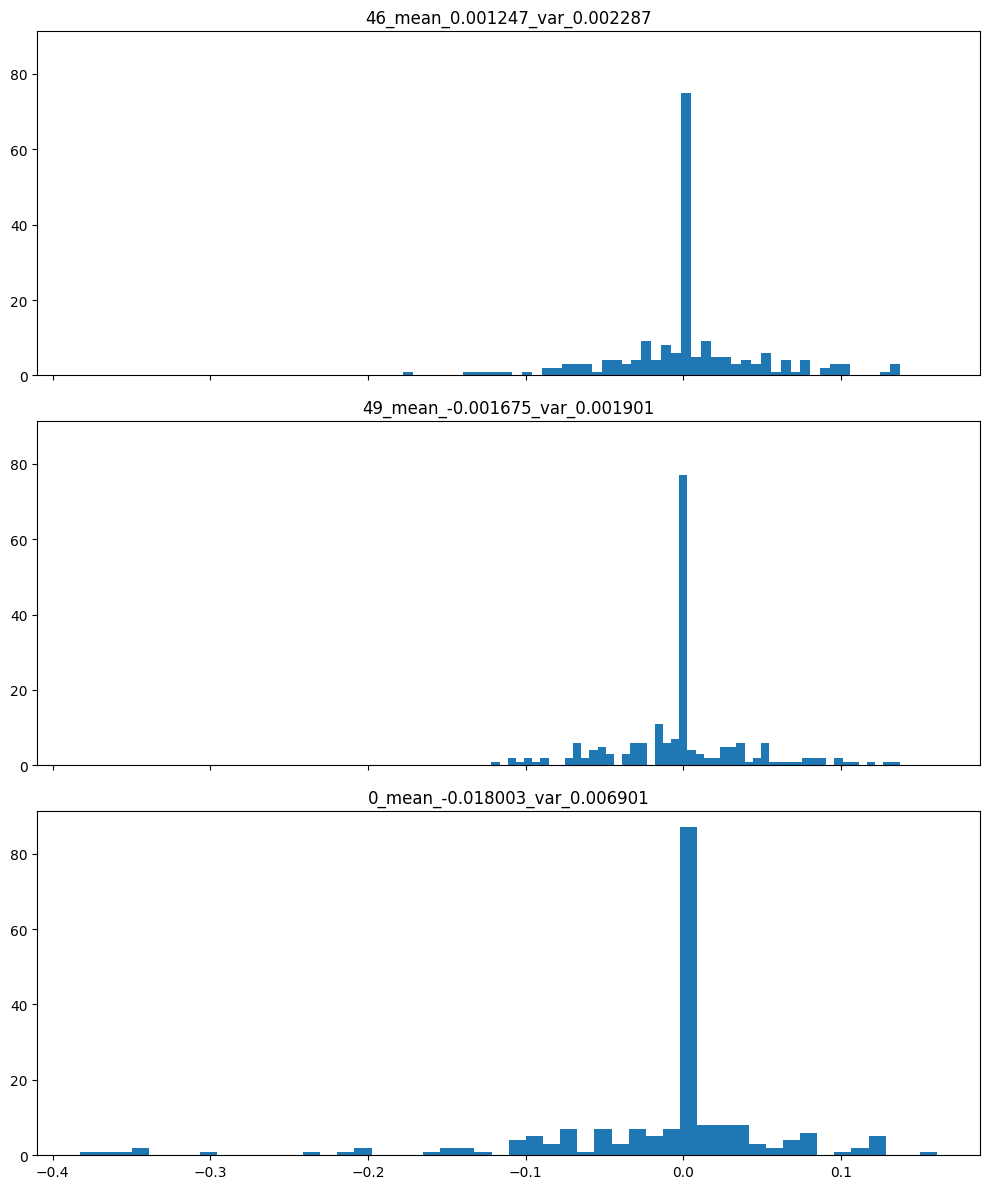

In [56]:
i=46
indexs = [i, 49, 0]
mlp_2_weight = state_dict_avg['mlp.network.2.weight'].cpu().numpy()
print(mlp_2_weight.shape)
fig, axs = plt.subplots(3, 1, figsize=(10,12), sharex=True, sharey=True)
axs[0].hist(mlp_2_weight[i].flatten(), bins = 50)
axs[0].set_title("%d_mean_%2f_var_%2f"%(i, mlp_2_weight[i].mean(), mlp_2_weight[i].var()))
axs[1].hist(mlp_2_weight[indexs[1]].flatten(), bins = 50)
axs[1].set_title("%d_mean_%2f_var_%2f"%(indexs[1], mlp_2_weight[indexs[1]].mean(), mlp_2_weight[indexs[1]].var()))
axs[2].hist(mlp_2_weight[indexs[2]].flatten(), bins = 50)
axs[2].set_title("%d_mean_%2f_var_%2f"%(indexs[2], mlp_2_weight[indexs[2]].mean(), mlp_2_weight[indexs[2]].var()))

plt.tight_layout()
plt.show()

In [68]:
mlp_2_weight[i]

array([-2.42396686e-02,  5.32480218e-02, -4.85121608e-02, -1.51028298e-02,
        8.90848637e-02,  6.66685402e-02,  4.82688993e-02, -3.01451851e-02,
        2.38055810e-02, -4.48921621e-02,  1.02096468e-01,  6.72020158e-03,
        4.57167104e-02,  4.09016199e-02,  2.32564961e-03, -5.14495783e-02,
        5.96539117e-02, -8.50370824e-02, -3.16772517e-03,  7.24935345e-03,
       -1.16952034e-02,  3.99309210e-02, -1.83325373e-02, -1.00270743e-02,
       -2.88755558e-02,  3.30035537e-02,  3.82869355e-02,  3.29440348e-02,
        4.23751734e-02,  2.69339401e-02,  2.82434709e-02, -4.44635609e-03,
       -3.95910218e-02, -1.14935875e-01, -3.31871100e-02, -2.85918675e-02,
        1.66544542e-02, -5.45118153e-02, -4.66138348e-02,  6.24240190e-03,
        5.13831042e-02, -4.44376506e-02,  4.45087105e-02,  2.65818345e-03,
        1.10386431e-01,  2.59762760e-02, -2.18152348e-02, -5.58838546e-02,
        9.60726812e-02, -2.33912282e-02,  1.36021841e-02, -5.80489519e-04,
        3.28290015e-02, -

In [63]:
mlp_1_weight = state_dict_avg['mlp.network.0.weight'].cpu().numpy()
print(mlp_1_weight.shape)

(200, 101)


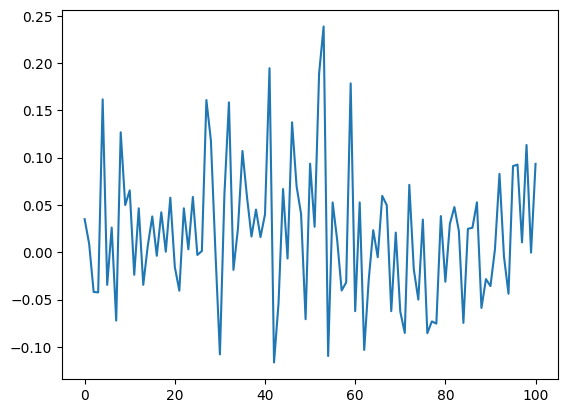

In [64]:
takein = np.matmul(mlp_2_weight[46], mlp_1_weight)
plt.plot(takein)

40


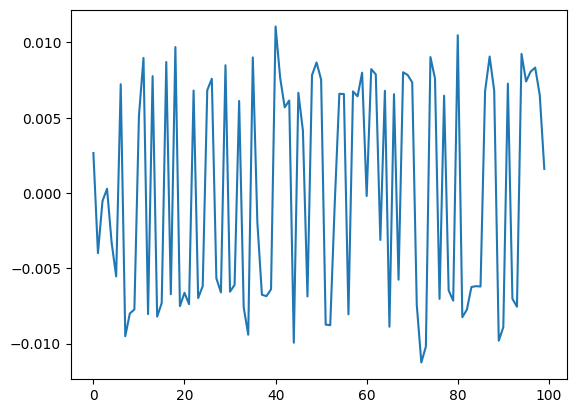

In [31]:
aghsgkj = mlp_2_weight.mean(axis = 1)
print(aghsgkj.argmax())
plt.plot(aghsgkj)

In [ ]:
np.mean()

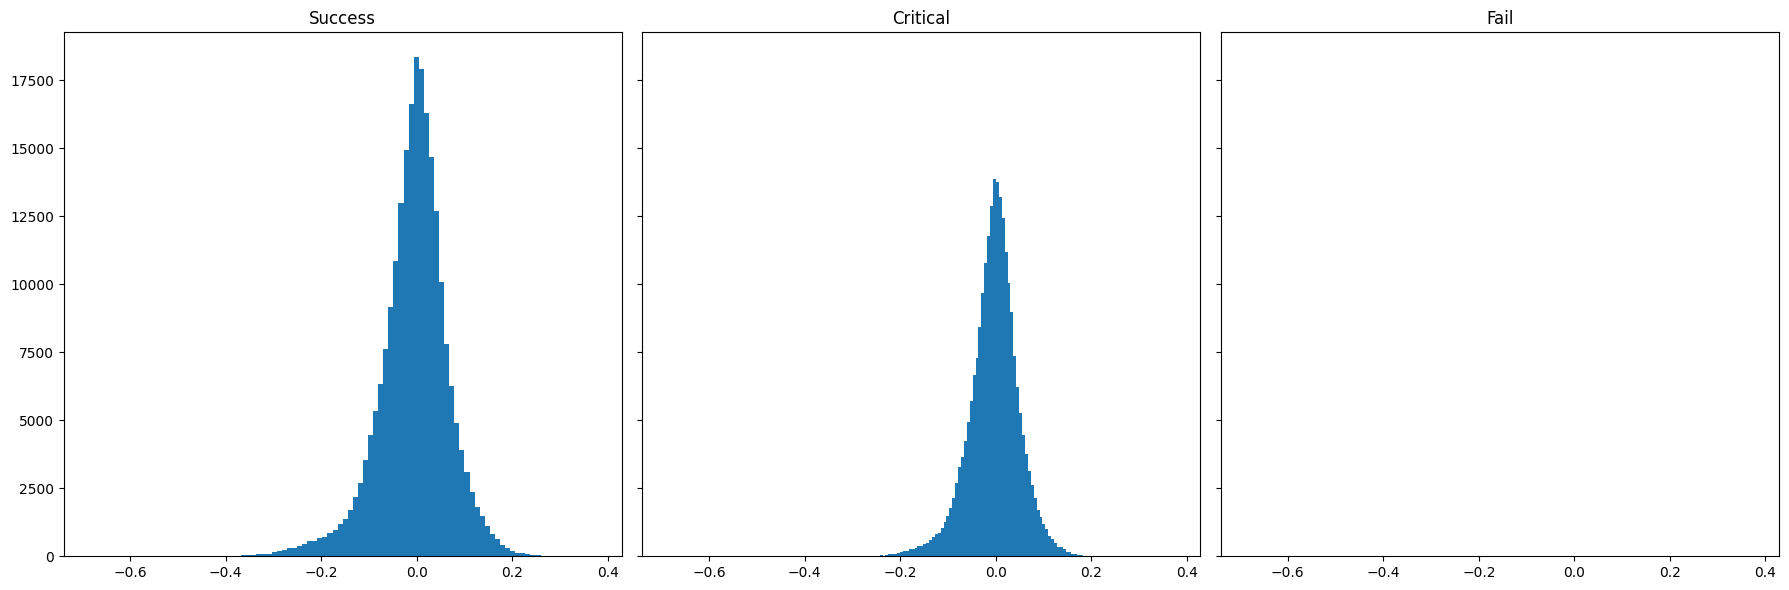

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
axs[0].hist(m_record_a.flatten(), bins=100)
axs[0].set_title("Success")
axs[1].hist(mlp_record_a.flatten(), bins=100)
axs[1].set_title("Critical")
#axs[2].hist(m_record_f.flatten(), bins=100)
axs[2].set_title("Fail")

plt.tight_layout()
plt.show()

In [47]:
state_dict_avg

OrderedDict([('_proto_w_s', tensor([0.7926], device='cuda:0')),
             ('tau_b', tensor([0.], device='cuda:0')),
             ('_proto_tau_m',
              tensor([ 5.0410, -0.6916, -1.8837, -2.8735, -4.0099, -4.3832, -9.9559, -5.0757,
                      -4.6670, -5.1283, -5.0050, -4.9775, -5.2928, -4.8281, -4.8797, -4.8807,
                      -4.8671, -5.0656, -4.9677, -5.0144, -4.9511, -4.8318, -5.1365, -4.8492,
                      -4.8464, -5.0022, -4.9712, -4.8783, -5.0413, -4.8963, -4.9937, -4.8015,
                      -5.3297, -4.8531, -4.9538, -4.8449, -4.6771, -4.6992, -4.9153, -4.9129,
                      -4.9995, -5.2251, -5.0997, -5.0212, -4.7963, -4.7962, -4.8469, -4.8624,
                      -4.9825, -4.7600], device='cuda:0')),
             ('input_to_synapse_indices', tensor([], device='cuda:0')),
             ('valid_indices_mask', tensor([], device='cuda:0')),
             ('mlp.network.0.weight',
              tensor([[ 4.4580e-02, -1.6597e-01,  8